In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import sys
import re
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words and stemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Import library for cross-validation
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
dframe = pd.read_csv('/content/drive/MyDrive/sentisum/sentisum-assessment-dataset.csv')
dframe.head()

,text
0,Tires where delivered to the garage of my choi...
1,"Easy Tyre Selection Process, Competitive Prici..."
2,Very easy to use and good value for money.
3,Really easy and convenient to arrange
4,It was so easy to select tyre sizes and arrang...


In [ ]:
stop_words = stopwords.words('english')
stop_words[-5:]

["weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
x_train = dframe[:9500]
x_test = dframe[9500:]

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = x_train.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['tires', 'where', 'delivered', 'to', 'the', 'garage', 'of', 'my', 'choice', 'the', 'garage', 'notified', 'me', 'when', 'they', 'had', 'been', 'delivered', 'day', 'and', 'time', 'was', 'arranged', 'with', 'the', 'garage', 'and', 'went', 'and', 'had', 'them', 'fitted', 'hassel', 'free', 'experience']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    # use 'en_core_web_sm' in place of 'en' 
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
len(data_ready)

9500

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

## Create corpus texts
texts = data_ready

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# View
display(corpus[:4])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 3),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1)],
 [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)],
 [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1)],
 [(0, 1), (19, 1), (24, 1), (25, 1)]]

[[('arrange', 1),
  ('choice', 1),
  ('day', 1),
  ('deliver', 2),
  ('experience', 1),
  ('fit', 1),
  ('free', 1),
  ('garage', 3),
  ('go', 1),
  ('notify', 1),
  ('time', 1),
  ('tire', 1)],
 [('competitive', 1),
  ('excellent', 1),
  ('fitting', 1),
  ('pricing', 1),
  ('process', 1),
  ('selection', 1),
  ('service', 1)],
 [('easy', 1), ('good', 1), ('money', 1), ('use', 1), ('value', 1)],
 [('arrange', 1), ('easy', 1), ('convenient', 1), ('really', 1)]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=18, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.114*"helpful" + 0.073*"know" + 0.060*"phone" + 0.058*"save" + '
  '0.049*"even" + 0.039*"ats" + 0.037*"certainly" + 0.032*"round" + '
  '0.028*"stock" + 0.027*"team"'),
 (1,
  '0.101*"take" + 0.084*"job" + 0.080*"company" + 0.076*"issue" + '
  '0.054*"select" + 0.036*"leave" + 0.022*"size" + 0.021*"feel" + '
  '0.021*"minute" + 0.018*"long"'),
 (2,
  '0.197*"would" + 0.167*"recommend" + 0.064*"definitely" + 0.058*"buy" + '
  '0.049*"highly" + 0.048*"redact" + 0.045*"service" + 0.038*"tyre" + '
  '0.027*"process" + 0.021*"whole"'),
 (3,
  '0.404*"good" + 0.169*"price" + 0.114*"service" + 0.066*"value" + '
  '0.037*"quality" + 0.036*"money" + 0.015*"fitter" + 0.011*"care" + '
  '0.009*"fair" + 0.008*"rate"'),
 (4,
  '0.183*"great" + 0.162*"service" + 0.108*"price" + 0.041*"excellent" + '
  '0.039*"tyre" + 0.039*"customer" + 0.037*"friendly" + 0.035*"competitive" + '
  '0.026*"happy" + 0.024*"time"'),
 (5,
  '0.211*"fitting" + 0.118*"efficient" + 0.088*"experience" + 0.064*"deli

In [ ]:
# Compute Perplexity
print(f"Perplexity: {lda_model.log_perplexity(corpus)}")  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Perplexity: -6.7090364820793065
Coherence Score: 0.41163964164769334


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.7425,"tyre, fit, car, day, garage, order, time, deli...","[tire, deliver, garage, choice, garage, notify..."
1,1,4.0,0.5069,"great, service, price, excellent, tyre, custom...","[selection, process, competitive, pricing, exc..."
2,2,3.0,0.4882,"good, price, service, value, quality, money, f...","[easy, use, good, value, money]"
3,3,5.0,0.4111,"fitting, efficient, experience, delivery, proc...","[really, easy, convenient, arrange]"
4,4,5.0,0.4996,"fitting, efficient, experience, delivery, proc...","[easy, select, size, arrange, local, fitting, ..."
5,5,10.0,0.6518,"excellent, service, quick, easy, simple, order...","[service, excellent, slight, downside, know, e..."
6,6,4.0,0.3816,"great, service, price, excellent, tyre, custom...","[friendly, website, competitive, price, good, ..."
7,7,4.0,0.7639,"great, service, price, excellent, tyre, custom...","[excellent, price, service]"
8,8,0.0,0.5139,"helpful, know, phone, save, even, ats, certain...","[great, even, know]"
9,9,16.0,0.4857,"tyre, garage, local, choose, fit, find, websit...","[use, local, garage]"


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 80

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6852,"helpful, know, phone, save, even, ats, certainly, round, stock, team","[beacause, best]"
1,1.0,0.5659,"take, job, company, issue, select, leave, size, feel, minute, long","[change, front, tyre, free, winter, check, result, van, coolant, tank, cap, ..."
2,2.0,0.8651,"would, recommend, definitely, buy, highly, redact, service, tyre, process, w...","[redact, exemplary, service, would, highly, recommend]"
3,3.0,0.8819,"good, price, service, value, quality, money, fitter, care, fair, rate","[incredible, service, amazing, price, outstanding, value, money]"
4,4.0,0.8819,"great, service, price, excellent, tyre, customer, friendly, competitive, hap...","[sportmax, great, price, service, importantly, great, tyre]"
5,5.0,0.8111,"fitting, efficient, experience, delivery, process, easy, arrange, brand, muc...","[easy, procurement, delivery, fitting]"
6,6.0,0.7639,"use, redact, need, first, fantastic, com, garage, never, better, cover","[use, redact, use]"
7,7.0,0.8426,"tyre, fit, car, day, garage, order, time, deliver, arrive, later","[wate, arrive, time, fit, time]"
8,8.0,0.8819,"time, appointment, change, book, fitting, tell, date, redact, tire, follow","[contacted, change, date, original, date, change, redact]"
9,9.0,0.8111,"well, way, tyre, brilliant, replace, deal, centre, mile, elsewhere, soon","[bloody, marvelous, wife, chuff]"


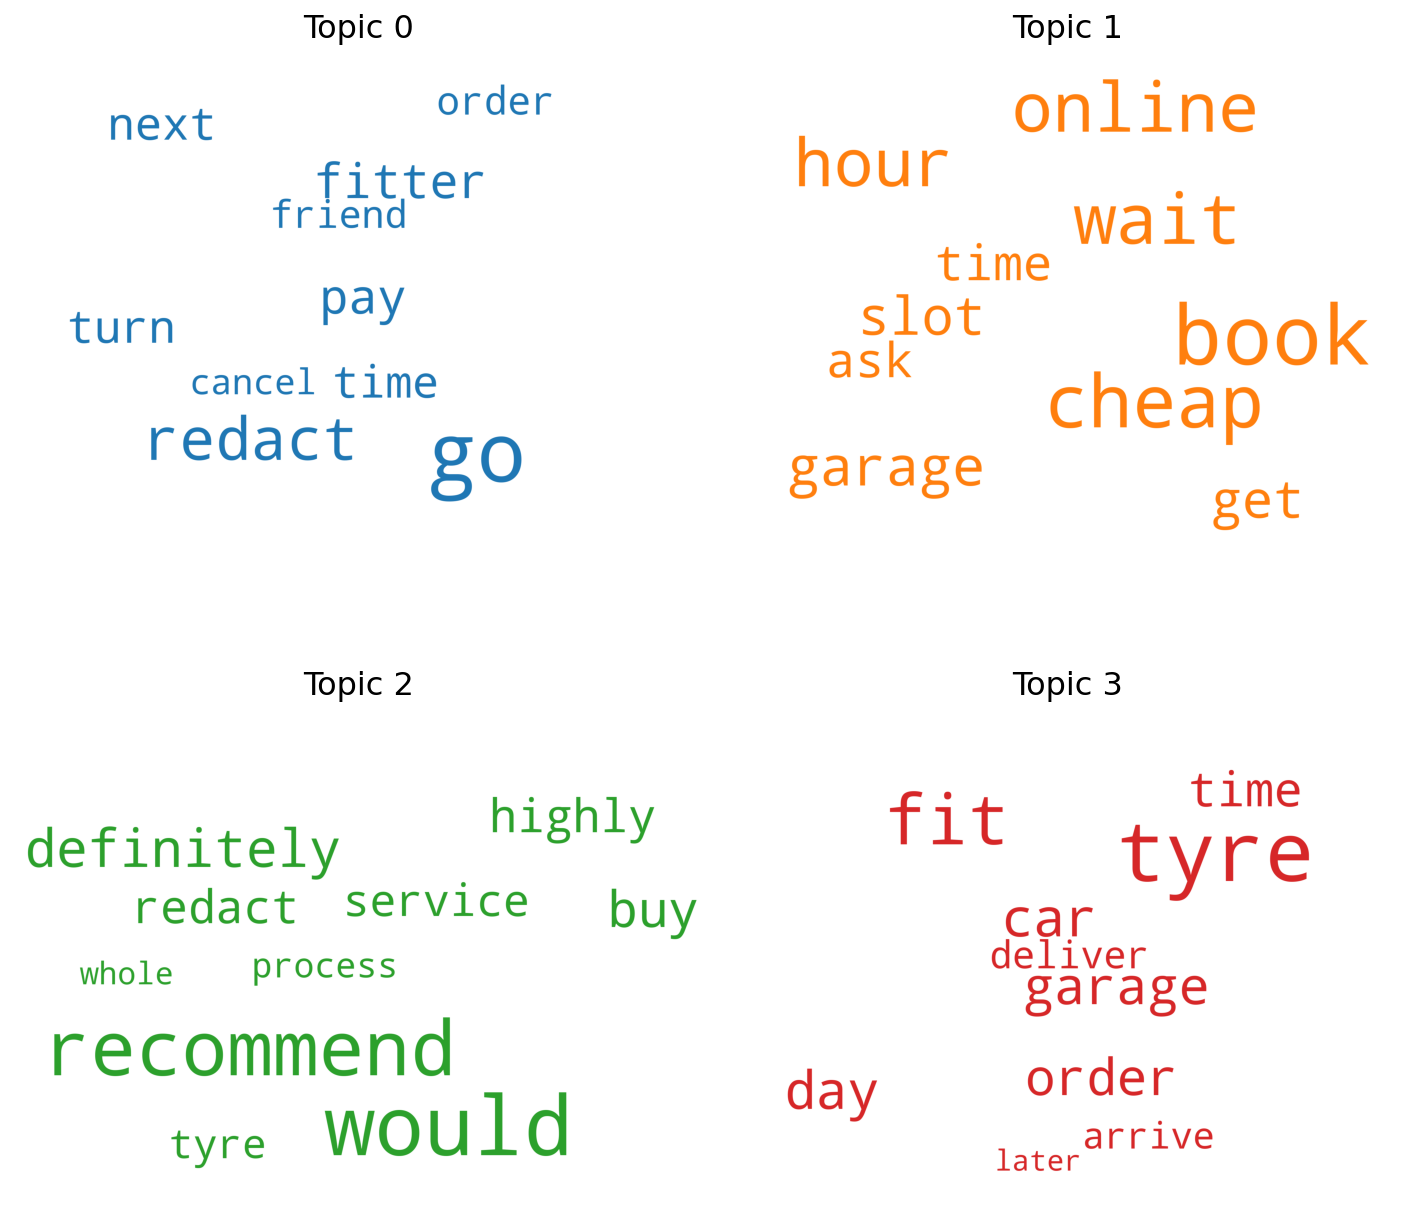

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
df_dominant_topic[df_dominant_topic['Document_No']==7]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
7,7,4.0,0.7639,"great, service, price, excellent, tyre, customer, friendly, competitive, hap...","[excellent, price, service]"


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42, update_every=1,\
                                                chunksize=100, passes=10, alpha='symmetric', iterations=100, per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=5, limit=60, step=12)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

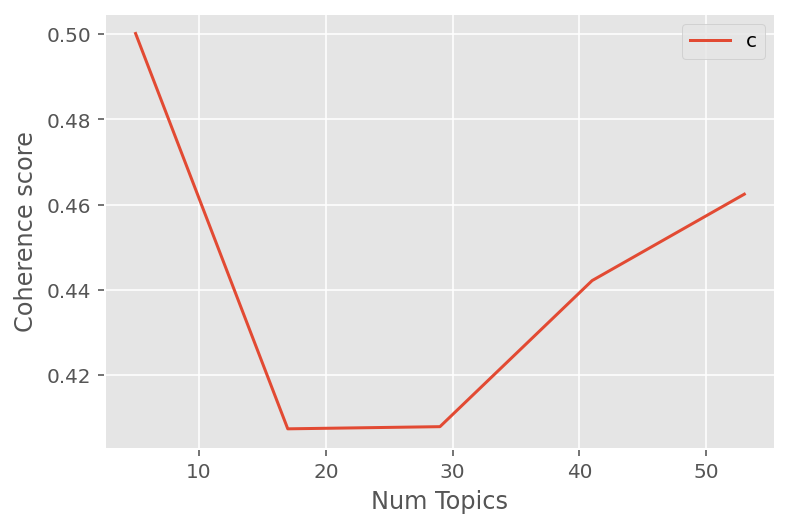

In [ ]:
# Show graph
limit=60; start=5; step=12;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5001
Num Topics = 17  has Coherence Value of 0.4073
Num Topics = 29  has Coherence Value of 0.4079
Num Topics = 41  has Coherence Value of 0.4421
Num Topics = 53  has Coherence Value of 0.4624


In [ ]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

[(6,
  '0.316*"time" + 0.113*"tyre" + 0.094*"take" + 0.088*"deliver" + '
  '0.054*"fitting"'),
 (16,
  '0.325*"easy" + 0.294*"use" + 0.124*"website" + 0.064*"price" + '
  '0.059*"delivery"'),
 (8,
  '0.367*"choice" + 0.085*"tyre" + 0.077*"site" + 0.067*"seem" + 0.061*"many"'),
 (36,
  '0.172*"wait" + 0.154*"hour" + 0.091*"garage" + 0.076*"ask" + '
  '0.033*"appoint"'),
 (14,
  '0.296*"experience" + 0.070*"set" + 0.067*"pressure" + 0.061*"family" + '
  '0.050*"partner"'),
 (10,
  '0.244*"customer" + 0.129*"service" + 0.065*"front" + 0.045*"delay" + '
  '0.038*"poor"'),
 (39,
  '0.285*"find" + 0.210*"simple" + 0.121*"turn" + 0.067*"correct" + '
  '0.029*"response"'),
 (18,
  '0.174*"appointment" + 0.099*"tell" + 0.077*"come" + 0.042*"time" + '
  '0.039*"cancel"'),
 (7, '0.216*"day" + 0.166*"go" + 0.070*"garage" + 0.066*"fit" + 0.057*"next"'),
 (28,
  '0.378*"fit" + 0.366*"tyre" + 0.088*"price" + 0.042*"range" + 0.014*"cover"'),
 (31,
  '0.233*"always" + 0.154*"call" + 0.142*"back" + 0.04

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
df_dominant_topic.to_csv('1st_task.csv')

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 80

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)
sent_topics_sorteddf_mallet.to_csv('2nd.csv')